In [1]:
import pandas as pd
import numpy as np
import scipy
import joblib, json, os, datetime 

In [2]:
import numpy as np
import pandas as pd
import os, json, datetime, sys
import lightgbm
import torch
from pytrend.numerai import (
    create_era_index,
    load_numerai_data,
    numerai_feature_correlation_matrix,
    numerai_factor_portfolio,
    dynamic_feature_neutralisation,
    run_numerai_models_performances,
)
import matplotlib.pyplot as plt

ImportError: cannot import name 'numerai_factor_portfolio' from 'pytrend.numerai' (/opt/conda/lib/python3.7/site-packages/pytrend/numerai.py)

In [ ]:
from pytrend.util import dynamic_model_selection_masks, walk_forward_dynamic_models, strategy_metrics

### Features Metadata

In [5]:
numerai_files = {
    "dataset": "../signals-data/numerai_signals_features_all.parquet",
    "feature_metadata": "../signals-data/numerai_signals_features_all_metadata.json",
}

In [6]:
with open(numerai_files["feature_metadata"],"r") as f:
    metadata = json.load(f)

In [7]:
metadata['feature_sets'].keys()

dict_keys(['stats', 'signature', 'catch22', 'ravenpack', 'financials'])

In [8]:
len(metadata['feature_sets']['stats'])

12

In [9]:
len(metadata['feature_sets']['signature'])

96

In [10]:
metadata['feature_sets']['catch22']

['feature_DN_HistogramMode_5_short_ranked',
 'feature_DN_HistogramMode_10_short_ranked',
 'feature_CO_f1ecac_short_ranked',
 'feature_CO_FirstMin_ac_short_ranked',
 'feature_CO_HistogramAMI_even_2_5_short_ranked',
 'feature_CO_trev_1_num_short_ranked',
 'feature_MD_hrv_classic_pnn40_short_ranked',
 'feature_SB_BinaryStats_mean_longstretch1_short_ranked',
 'feature_SB_TransitionMatrix_3ac_sumdiagcov_short_ranked',
 'feature_PD_PeriodicityWang_th0_01_short_ranked',
 'feature_CO_Embed2_Dist_tau_d_expfit_meandiff_short_ranked',
 'feature_IN_AutoMutualInfoStats_40_gaussian_fmmi_short_ranked',
 'feature_FC_LocalSimple_mean1_tauresrat_short_ranked',
 'feature_DN_OutlierInclude_p_001_mdrmd_short_ranked',
 'feature_DN_OutlierInclude_n_001_mdrmd_short_ranked',
 'feature_SP_Summaries_welch_rect_area_5_1_short_ranked',
 'feature_SB_BinaryStats_diff_longstretch0_short_ranked',
 'feature_SB_MotifThree_quantile_hh_short_ranked',
 'feature_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1_short_ranked',
 'f

In [11]:
all_data = pd.read_parquet(numerai_files['dataset'])

In [12]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1788132 entries, (20030131, 'A US') to (20211231, 'ZTS US')
Columns: 588 entries, era to feature_zerotradeAlt12_ranked
dtypes: datetime64[ns](1), float64(5), int8(582)
memory usage: 1.1+ GB


In [13]:
all_data.columns

Index(['era', 'target_4d', 'target_20d', 'raw_return_target_20d',
       'factor_neutral_target_20d', 'factor_feat_neutral_target_20d',
       'feature_momentum_21_ranked', 'feature_momentum_63_ranked',
       'feature_momentum_252_ranked', 'feature_volatility_21_ranked',
       ...
       'feature_TrendFactor_ranked', 'feature_UpRecomm_ranked',
       'feature_VarCF_ranked', 'feature_VolMkt_ranked', 'feature_VolSD_ranked',
       'feature_VolumeTrend_ranked', 'feature_XFIN_ranked',
       'feature_zerotrade_ranked', 'feature_zerotradeAlt1_ranked',
       'feature_zerotradeAlt12_ranked'],
      dtype='object', length=588)

## Debug Models

    - Check that models can be correctly loaded 

In [4]:
import joblib, os
import pandas as pd
from pytrend.benchmark import benchmark_pipeline, save_best_model, load_best_model

In [22]:
for method in ['lightgbm',]:
    for seed in range(0,7000,1000):
        parametername = f'../numerai-signals-models/{method}_None_1_{seed}.parameters' 
        if os.path.exists(parametername):
            modelname = parametername.replace('.parameters','.model')
            parameters = joblib.load(parametername)
            most_recent_model = load_best_model(parameters['parameters']['model']['tabular_model'],modelname)
            print(seed,
                  parameters['parameters']['model']['train_start'],
                  parameters['parameters']['model']['train_end'],
                  parameters['parameters']['model']['validation_start'],
                  parameters['parameters']['model']['validation_end'])
            print(seed,parameters['parameters']['model']['target_columns'])
            print(seed,len(parameters['parameters']['model']['feature_columns']),parameters['parameters']['model']['feature_columns'][0])
            #ax = lightgbm.plot_importance(most_recent_model,max_num_features=40,figsize=(20,20))
            #most_recent_model = load_best_model(parameters['parameters']['model']['tabular_model'],modelname)
            #print(seed,most_recent_model.num_trees())
            if False:
                live_data = pd.read_parquet('../data/v4_live_data_int8.parquet')
                feature_cols = parameters['parameters']['model']['feature_columns']
                live_data[feature_cols] = live_data[feature_cols].fillna(2) - 2
                if parameters['transformer']:
                    sample = parameters['transformer'].transform(live_data[feature_cols],is_train=False)
                else:
                    sample = live_data[feature_cols]
                
                feature_importance = pd.DataFrame(most_recent_model.feature_importance(),index=sample.columns,columns=['feature_importance'])
                feature_diffs = set(most_recent_model.feature_name()) - set(sample.columns)
                assert len(feature_diffs) == 0
                live_preds = most_recent_model.predict(sample)
                assert len(live_preds) == sample.shape[0]
                #most_recent_model.refit(sample,live_data['target'])

0 2003-01-31 00:00:00 2010-12-31 00:00:00 2012-01-06 00:00:00 2015-12-25 00:00:00
0 Index(['target_20d'], dtype='object')
0 582 feature_momentum_21_ranked
1000 2003-01-31 00:00:00 2010-12-31 00:00:00 2012-01-06 00:00:00 2015-12-25 00:00:00
1000 Index(['target_20d'], dtype='object')
1000 96 feature_lookback_21_signature_0_ranked
2000 2003-01-31 00:00:00 2010-12-31 00:00:00 2012-01-06 00:00:00 2015-12-25 00:00:00
2000 Index(['target_20d'], dtype='object')
2000 66 feature_DN_HistogramMode_5_short_ranked
3000 2003-01-31 00:00:00 2010-12-31 00:00:00 2012-01-06 00:00:00 2015-12-25 00:00:00
3000 Index(['target_20d'], dtype='object')
3000 12 feature_momentum_21_ranked
4000 2003-01-31 00:00:00 2010-12-31 00:00:00 2012-01-06 00:00:00 2015-12-25 00:00:00
4000 Index(['target_20d'], dtype='object')
4000 204 feature_AbnormalAccruals_ranked
5000 2003-01-31 00:00:00 2010-12-31 00:00:00 2012-01-06 00:00:00 2015-12-25 00:00:00
5000 Index(['target_20d'], dtype='object')
5000 204 feature_rp_EventSentiment

In [23]:
parameters['parameters']['tabular']

{'seed': 6000,
 'num_iterations': 950,
 'learning_rate': 0.023533845080874905,
 'min_data_in_leaf': 2500,
 'feature_fraction': 0.1,
 'lambda_l1': 0.0175796840948161,
 'lambda_l2': 0.07758250297173153,
 'bagging_fraction': 0.55,
 'bagging_freq': 30,
 'drop_rate': 0.15000000000000002,
 'skip_drop': 0.2,
 'top_rate': 0.15000000000000002,
 'other_rate': 0.05,
 'boosting': 'gbdt',
 'early_stopping_round': 5000,
 'objective': 'regression',
 'device_type': 'gpu',
 'num_threads': 0,
 'verbosity': -1,
 'num_gpu': 1,
 'max_bin': 7,
 'gpu_use_dp': False}

In [24]:
most_recent_model.num_trees()

117

In [25]:
parameters

{'parameters': {'feature_eng': {'seed': 6000},
  'tabular': {'seed': 6000,
   'num_iterations': 950,
   'learning_rate': 0.023533845080874905,
   'min_data_in_leaf': 2500,
   'feature_fraction': 0.1,
   'lambda_l1': 0.0175796840948161,
   'lambda_l2': 0.07758250297173153,
   'bagging_fraction': 0.55,
   'bagging_freq': 30,
   'drop_rate': 0.15000000000000002,
   'skip_drop': 0.2,
   'top_rate': 0.15000000000000002,
   'other_rate': 0.05,
   'boosting': 'gbdt',
   'early_stopping_round': 5000,
   'objective': 'regression',
   'device_type': 'gpu',
   'num_threads': 0,
   'verbosity': -1,
   'num_gpu': 1,
   'max_bin': 7,
   'gpu_use_dp': False},
  'additional': {},
  'model': {'test_size': 208,
   'valid_splits': 1,
   'max_train_size': None,
   'gap': 52,
   'cross_validation': 'GroupedTimeSeriesSplit',
   'feature_columns': Index(['feature_momentum_21_ranked', 'feature_momentum_63_ranked',
          'feature_momentum_252_ranked', 'feature_volatility_21_ranked',
          'feature_vola

### Model Performances in CV 0

In [11]:
import os, glob
import pandas as pd
from pytrend import strategy_metrics 

In [12]:
### Compare Against All Trained Models 

performances_files = sorted(glob.glob(f'../numerai-signals-performances/*.csv'))

models_list = list()
for file in performances_files:
    model_no = int(file.split('_')[-2])
    model_seq = int(file.split('_')[-1].split('.')[0])
    if os.path.isfile(file) and model_no % 1000 == 0:
        df = pd.read_csv(file,index_col=0).sort_index()
        df = df[~df.index.duplicated()]
        if (df.shape[0]>=52*6) and (df.shape[0]<=10000):
        # if (df.shape[0]>=2) and (df.shape[0]<=10000):    
            models_list.append(df.iloc[26:,:])
            print(file,df.index[26], df.index[-1],)

../numerai-signals-performances/lightgbm_None_1_0_20.csv 2016-06-24 2021-12-31
../numerai-signals-performances/lightgbm_None_1_1000_20.csv 2016-06-24 2021-12-31
../numerai-signals-performances/lightgbm_None_1_2000_20.csv 2016-06-24 2021-12-31
../numerai-signals-performances/lightgbm_None_1_3000_20.csv 2016-06-24 2021-12-31
../numerai-signals-performances/lightgbm_None_1_4000_20.csv 2016-06-24 2021-12-31
../numerai-signals-performances/lightgbm_None_1_5000_20.csv 2016-06-24 2021-12-31
../numerai-signals-performances/lightgbm_None_1_6000_20.csv 2016-06-24 2021-12-31


In [13]:
pd.DataFrame(pd.concat(models_list,axis=1).apply(strategy_metrics).to_dict()).transpose()[['sharpe','calmar','mean','volatility','max_drawdown']]

,sharpe,calmar,mean,volatility,max_drawdown
lightgbm_None_1_0_20-baseline,0.4714,0.0516,0.0142,0.0302,0.2751
lightgbm_None_1_1000_20-baseline,0.1987,0.0136,0.0056,0.0284,0.4116
lightgbm_None_1_2000_20-baseline,0.1823,0.0079,0.0053,0.0293,0.6742
lightgbm_None_1_3000_20-baseline,0.2074,0.0141,0.0063,0.0304,0.4456
lightgbm_None_1_4000_20-baseline,0.2998,0.0206,0.0087,0.0290,0.4223
lightgbm_None_1_5000_20-baseline,0.6854,0.1501,0.0178,0.0260,0.1186
lightgbm_None_1_6000_20-baseline,0.2963,0.0163,0.0093,0.0313,0.5697


### Model Performances in CV 1

In [14]:
### Compare Against All Trained Models 

performances_files = sorted(glob.glob(f'../numerai-signals-performances/*.csv'))

models_list = list()
for file in performances_files:
    model_no = int(file.split('_')[-2])
    model_seq = int(file.split('_')[-1].split('.')[0])
    if os.path.isfile(file) and model_no % 1000 == 20:
        df = pd.read_csv(file,index_col=0).sort_index()
        df = df[~df.index.duplicated()]
        if (df.shape[0]<=10000):
        # if (df.shape[0]>=2) and (df.shape[0]<=10000):    
            models_list.append(df.iloc[26:,:])
            print(file,df.index[26], df.index[-1],)

../numerai-signals-performances/lightgbm_None_1_1020_20.csv 2017-06-30 2021-12-31
../numerai-signals-performances/lightgbm_None_1_2020_20.csv 2017-06-30 2021-12-31
../numerai-signals-performances/lightgbm_None_1_20_20.csv 2017-06-30 2021-12-31
../numerai-signals-performances/lightgbm_None_1_3020_20.csv 2017-06-30 2021-12-31
../numerai-signals-performances/lightgbm_None_1_4020_20.csv 2017-06-30 2021-12-31
../numerai-signals-performances/lightgbm_None_1_5020_20.csv 2017-06-30 2021-12-31
../numerai-signals-performances/lightgbm_None_1_6020_20.csv 2017-06-30 2021-12-31


In [15]:
pd.DataFrame(pd.concat(models_list,axis=1).apply(strategy_metrics).to_dict()).transpose()[['sharpe','calmar','mean','volatility','max_drawdown']]

,sharpe,calmar,mean,volatility,max_drawdown
lightgbm_None_1_1020_20-baseline,0.1997,0.0110,0.0061,0.0307,0.5546
lightgbm_None_1_2020_20-baseline,0.1632,0.0077,0.0048,0.0294,0.6262
lightgbm_None_1_20_20-baseline,0.5158,0.0736,0.0147,0.0286,0.1996
lightgbm_None_1_3020_20-baseline,0.1600,0.0132,0.0050,0.0310,0.3789
lightgbm_None_1_4020_20-baseline,0.3101,0.0293,0.0082,0.0264,0.2794
lightgbm_None_1_5020_20-baseline,0.5324,0.0816,0.0168,0.0315,0.2060
lightgbm_None_1_6020_20-baseline,0.2595,0.0158,0.0085,0.0327,0.5379


### Model Performances in CV 2

In [16]:
### Compare Against All Trained Models 

performances_files = sorted(glob.glob(f'../numerai-signals-performances/*.csv'))

models_list = list()
for file in performances_files:
    model_no = int(file.split('_')[-2])
    model_seq = int(file.split('_')[-1].split('.')[0])
    if os.path.isfile(file) and model_no % 1000 == 40:
        df = pd.read_csv(file,index_col=0).sort_index()
        df = df[~df.index.duplicated()]
        if (df.shape[0]<=10000):
        # if (df.shape[0]>=2) and (df.shape[0]<=10000):    
            models_list.append(df.iloc[26:,:])
            print(file,df.index[26], df.index[-1],)

../numerai-signals-performances/lightgbm_None_1_1040_20.csv 2018-06-29 2021-12-31
../numerai-signals-performances/lightgbm_None_1_2040_20.csv 2018-06-29 2021-12-31
../numerai-signals-performances/lightgbm_None_1_3040_20.csv 2018-06-29 2021-12-31
../numerai-signals-performances/lightgbm_None_1_4040_20.csv 2018-06-29 2021-12-31
../numerai-signals-performances/lightgbm_None_1_40_20.csv 2018-06-29 2021-12-31
../numerai-signals-performances/lightgbm_None_1_5040_20.csv 2018-06-29 2021-12-31
../numerai-signals-performances/lightgbm_None_1_6040_20.csv 2018-06-29 2021-12-31


In [17]:
pd.DataFrame(pd.concat(models_list,axis=1).apply(strategy_metrics).to_dict()).transpose()[['sharpe','calmar','mean','volatility','max_drawdown']]

,sharpe,calmar,mean,volatility,max_drawdown
lightgbm_None_1_1040_20-baseline,0.2191,0.0140,0.0062,0.0283,0.4440
lightgbm_None_1_2040_20-baseline,0.1470,0.0073,0.0043,0.0295,0.5911
lightgbm_None_1_3040_20-baseline,0.1994,0.0135,0.0061,0.0308,0.4518
lightgbm_None_1_4040_20-baseline,0.4416,0.0583,0.0111,0.0252,0.1903
lightgbm_None_1_40_20-baseline,0.6706,0.1728,0.0187,0.0279,0.1082
lightgbm_None_1_5040_20-baseline,0.7083,0.2329,0.0222,0.0313,0.0953
lightgbm_None_1_6040_20-baseline,0.2778,0.0176,0.0086,0.0310,0.4876


### Model Performances in CV 3

In [18]:
### Compare Against All Trained Models 

performances_files = sorted(glob.glob(f'../numerai-signals-performances/*.csv'))

models_list = list()
for file in performances_files:
    model_no = int(file.split('_')[-2])
    model_seq = int(file.split('_')[-1].split('.')[0])
    if os.path.isfile(file) and model_no % 1000 == 60:
        df = pd.read_csv(file,index_col=0).sort_index()
        df = df[~df.index.duplicated()]
        if (df.shape[0]<=10000):
        # if (df.shape[0]>=2) and (df.shape[0]<=10000):    
            models_list.append(df.iloc[26:,:])
            print(file,df.index[26], df.index[-1],)

../numerai-signals-performances/lightgbm_None_1_1060_20.csv 2019-06-28 2021-12-31
../numerai-signals-performances/lightgbm_None_1_2060_20.csv 2019-06-28 2021-12-31
../numerai-signals-performances/lightgbm_None_1_3060_20.csv 2019-06-28 2021-12-31
../numerai-signals-performances/lightgbm_None_1_4060_20.csv 2019-06-28 2021-12-31
../numerai-signals-performances/lightgbm_None_1_5060_20.csv 2019-06-28 2021-12-31
../numerai-signals-performances/lightgbm_None_1_6060_20.csv 2019-06-28 2021-12-31
../numerai-signals-performances/lightgbm_None_1_60_20.csv 2019-06-28 2021-12-31


In [19]:
pd.DataFrame(pd.concat(models_list,axis=1).apply(strategy_metrics).to_dict()).transpose()[['sharpe','calmar','mean','volatility','max_drawdown']]

,sharpe,calmar,mean,volatility,max_drawdown
lightgbm_None_1_1060_20-baseline,0.3672,0.0562,0.0105,0.0285,0.1868
lightgbm_None_1_2060_20-baseline,0.3522,0.0473,0.0099,0.0281,0.2093
lightgbm_None_1_3060_20-baseline,0.3586,0.0377,0.0103,0.0287,0.2735
lightgbm_None_1_4060_20-baseline,0.4748,0.0723,0.0109,0.0229,0.1507
lightgbm_None_1_5060_20-baseline,0.7816,0.2505,0.0278,0.0356,0.1110
lightgbm_None_1_6060_20-baseline,0.4544,0.0679,0.0140,0.0307,0.2062
lightgbm_None_1_60_20-baseline,0.7886,0.3249,0.0218,0.0276,0.0671


### Model Performances in CV 4

In [20]:
### Compare Against All Trained Models 

performances_files = sorted(glob.glob(f'../numerai-signals-performances/*.csv'))

models_list = list()
for file in performances_files:
    model_no = int(file.split('_')[-2])
    model_seq = int(file.split('_')[-1].split('.')[0])
    if os.path.isfile(file) and model_no % 1000 == 80:
        df = pd.read_csv(file,index_col=0).sort_index()
        df = df[~df.index.duplicated()]
        if (df.shape[0]<=10000):
        # if (df.shape[0]>=2) and (df.shape[0]<=10000):    
            models_list.append(df.iloc[26:,:])
            print(file,df.index[26], df.index[-1],)

../numerai-signals-performances/lightgbm_None_1_1080_20.csv 2020-06-26 2021-12-31
../numerai-signals-performances/lightgbm_None_1_2080_20.csv 2020-06-26 2021-12-31
../numerai-signals-performances/lightgbm_None_1_3080_20.csv 2020-06-26 2021-12-31
../numerai-signals-performances/lightgbm_None_1_4080_20.csv 2020-06-26 2021-12-31
../numerai-signals-performances/lightgbm_None_1_5080_20.csv 2020-06-26 2021-12-31
../numerai-signals-performances/lightgbm_None_1_6080_20.csv 2020-06-26 2021-12-31
../numerai-signals-performances/lightgbm_None_1_80_20.csv 2020-06-26 2021-12-31


In [21]:
pd.DataFrame(pd.concat(models_list,axis=1).apply(strategy_metrics).to_dict()).transpose()[['sharpe','calmar','mean','volatility','max_drawdown']]

,sharpe,calmar,mean,volatility,max_drawdown
lightgbm_None_1_1080_20-baseline,0.3561,0.0486,0.0104,0.0292,0.2139
lightgbm_None_1_2080_20-baseline,0.3473,0.0471,0.0101,0.0291,0.2144
lightgbm_None_1_3080_20-baseline,0.2716,0.0279,0.0075,0.0276,0.2688
lightgbm_None_1_4080_20-baseline,0.3225,0.0468,0.0079,0.0245,0.1687
lightgbm_None_1_5080_20-baseline,0.9987,0.3846,0.0335,0.0335,0.0871
lightgbm_None_1_6080_20-baseline,0.3763,0.0543,0.0123,0.0326,0.2265
lightgbm_None_1_80_20-baseline,0.8342,0.3758,0.0239,0.0287,0.0636


## Dynamic Model Selection

In [36]:
import os, glob
import pandas as pd
from pytrend import strategy_metrics 
from pytrend import load_best_model 
from pytrend.util import dynamic_model_selection_masks, walk_forward_dynamic_models

In [37]:
### Compare Against All Trained Models 

performances_files = sorted(glob.glob(f'../numerai-signals-performances/*.csv'))

models_list = list()
for file in performances_files:
    model_no = int(file.split('_')[-2])
    model_seq = int(file.split('_')[-1].split('.')[0])
    if os.path.isfile(file):
        df = pd.read_csv(file,index_col=0).sort_index()
        df = df[~df.index.duplicated()]
        if (df.shape[0]>=52*6) and (df.shape[0]<=10000):
        # if (df.shape[0]>=2) and (df.shape[0]<=10000):    
            models_list.append(df.iloc[26:,:])
            print(file, df.index[-1],)

../numerai-signals-performances/lightgbm_None_1_0_20.csv 2021-12-31
../numerai-signals-performances/lightgbm_None_1_1000_20.csv 2021-12-31
../numerai-signals-performances/lightgbm_None_1_100_20.csv 2021-12-31
../numerai-signals-performances/lightgbm_None_1_1100_20.csv 2021-12-31
../numerai-signals-performances/lightgbm_None_1_1200_20.csv 2021-12-31
../numerai-signals-performances/lightgbm_None_1_1300_20.csv 2021-12-31
../numerai-signals-performances/lightgbm_None_1_1400_20.csv 2021-12-31
../numerai-signals-performances/lightgbm_None_1_2000_20.csv 2021-12-31
../numerai-signals-performances/lightgbm_None_1_200_20.csv 2021-12-31
../numerai-signals-performances/lightgbm_None_1_2100_20.csv 2021-12-31
../numerai-signals-performances/lightgbm_None_1_2200_20.csv 2021-12-31
../numerai-signals-performances/lightgbm_None_1_2300_20.csv 2021-12-31
../numerai-signals-performances/lightgbm_None_1_2400_20.csv 2021-12-31
../numerai-signals-performances/lightgbm_None_1_3000_20.csv 2021-12-31
../numerai-

In [38]:
dynamic_models_collection = walk_forward_dynamic_models(models_list)

### Selecting Top Models
    
    
    - To optimise Momentum, simply use historical momentum 
    - To optimise Sharpe, historical sharpe/calmar are good indicators
    - To optimise Calmar, it is feature set dependent. For Baseline, use skew/kurtosis. For Small and Ensemble, use sharpe/drawdown
    - These rules dependent on how diverse the set of trained models. 
    

In [41]:
for Sets in ['Baseline', "Optimizer", 'Small',  "Standard", ]:
    print(Sets,dynamic_models_collection[Sets].shape[1])

Baseline 30
Optimizer 0
Small 0
Standard 0


In [43]:
recent_results = list()
portfolios = dict()
lookback = 52
gap = 6
report_days = 10000
criteria = ['calmar_max','sharpe_max', 'mean_max', 'drawdown_min',]

for Sets in ['Baseline', ]:
    for no_tops in [5]:
        #dynamic_models_collection = walk_forward_dynamic_models(models_list)
        dynamic_masks = dynamic_model_selection_masks(dynamic_models_collection[Sets].sort_index(),
                                                      top_models=no_tops,lookback=lookback,gap=gap)
        for method in criteria:
            portfolio = (dynamic_masks[method]*dynamic_models_collection[Sets].sort_index()).sum(axis=1,min_count=1)
            portfolio.fillna(dynamic_models_collection[Sets].sort_index().mean(axis=1),inplace=True)
            performances = strategy_metrics(portfolio.tail(report_days))
            performances['method'] = method
            performances['no_tops'] = no_tops   
            performances['sets'] = Sets
            recent_results.append(performances)
            portfolios[f"{Sets}_{method}_{no_tops}"] = portfolio.tail(report_days)
    
    if False:
        portfolio = dynamic_models_collection[Sets].sort_index().mean(axis=1)
        performances = strategy_metrics(portfolio.tail(report_days))  
        performances['method'] = 'average'
        performances['no_tops'] = 0   
        performances['sets'] = Sets
        recent_results.append(performances)
        portfolios[f"{Sets}_average_0"] = portfolio.tail(report_days)    

In [44]:
pd.DataFrame(recent_results).dropna().sort_values(['mean']).tail(3)

,mean,volatility,skew,kurtosis,max_drawdown,sharpe,calmar,method,no_tops,sets
1,0.0113,0.0190,0.1444,-0.2045,0.1127,0.5940,0.1003,sharpe_max,5,Baseline
0,0.0121,0.0188,0.4072,0.2522,0.1000,0.6443,0.1210,calmar_max,5,Baseline
3,0.0130,0.0201,0.4870,0.9820,0.1474,0.6490,0.0882,drawdown_min,5,Baseline


In [45]:
pd.DataFrame(recent_results).dropna().sort_values(['calmar']).tail(3)

,mean,volatility,skew,kurtosis,max_drawdown,sharpe,calmar,method,no_tops,sets
3,0.0130,0.0201,0.4870,0.9820,0.1474,0.6490,0.0882,drawdown_min,5,Baseline
1,0.0113,0.0190,0.1444,-0.2045,0.1127,0.5940,0.1003,sharpe_max,5,Baseline
0,0.0121,0.0188,0.4072,0.2522,0.1000,0.6443,0.1210,calmar_max,5,Baseline


In [46]:
pd.DataFrame(recent_results).dropna().sort_values(['sharpe']).tail(3)

,mean,volatility,skew,kurtosis,max_drawdown,sharpe,calmar,method,no_tops,sets
1,0.0113,0.0190,0.1444,-0.2045,0.1127,0.5940,0.1003,sharpe_max,5,Baseline
0,0.0121,0.0188,0.4072,0.2522,0.1000,0.6443,0.1210,calmar_max,5,Baseline
3,0.0130,0.0201,0.4870,0.9820,0.1474,0.6490,0.0882,drawdown_min,5,Baseline


<AxesSubplot:xlabel='era'>

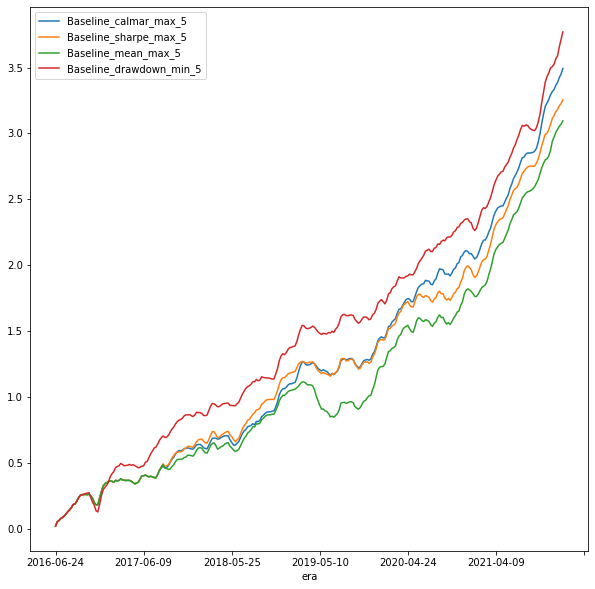

In [47]:
pd.DataFrame(portfolios).cumsum().plot(figsize=(10,10),logy=False)

In [48]:
leaderboard = pd.DataFrame(
    dynamic_models_collection["Baseline"]
    .sort_index()
    .iloc[:]
    .apply(strategy_metrics)
    .to_dict()
).transpose()

leaderboard.sort_values('sharpe')

,mean,volatility,skew,kurtosis,max_drawdown,sharpe,calmar
lightgbm_None_1_2100_20-baseline,-0.0000,0.0282,-0.2078,0.3931,0.6399,-0.0018,-0.0000
lightgbm_None_1_2400_20-baseline,0.0013,0.0282,0.0572,-0.3861,0.8987,0.0450,0.0014
lightgbm_None_1_4100_20-baseline,0.0017,0.0279,-0.0654,0.9579,0.9355,0.0616,0.0018
lightgbm_None_1_1400_20-baseline,0.0023,0.0285,0.3865,0.2482,0.4817,0.0811,0.0048
lightgbm_None_1_2200_20-baseline,0.0042,0.0302,-0.1790,-0.2075,0.8739,0.1387,0.0048
lightgbm_None_1_3400_20-baseline,0.0042,0.0269,0.1066,-0.2194,0.4136,0.1546,0.0102
lightgbm_None_1_2000_20-baseline,0.0053,0.0293,-0.1372,-0.1943,0.6742,0.1823,0.0079
lightgbm_None_1_3300_20-baseline,0.0056,0.0292,0.2141,-0.1584,0.3332,0.1925,0.0168
lightgbm_None_1_3200_20-baseline,0.0060,0.0307,0.3213,0.5040,0.4222,0.1954,0.0142
lightgbm_None_1_1200_20-baseline,0.0058,0.0293,0.1766,0.0918,0.5947,0.1973,0.0098


<AxesSubplot:xlabel='era'>

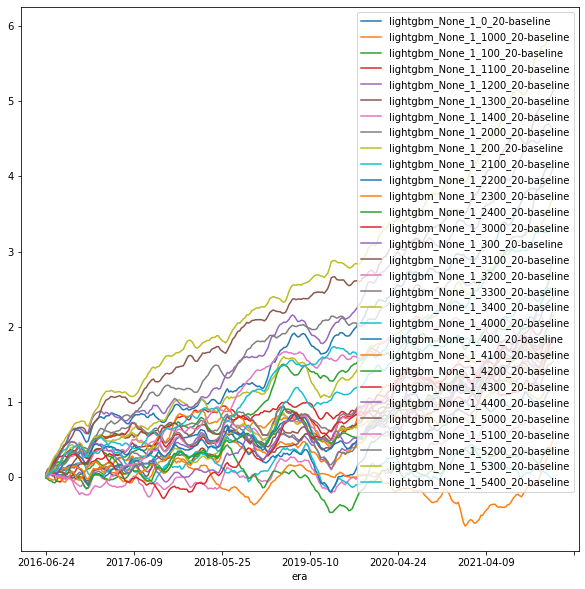

In [49]:
dynamic_models_collection["Baseline"].cumsum().plot(figsize=(10,10))

In [50]:
import glob

def create_leaderboard(performances_folder, models_subset="Small", lookback=52):
    performances_files = sorted(glob.glob(f"{performances_folder}/*.csv"))
    models_list = list()
    for f in performances_files:
        model_no = int(f.split(".csv")[0].split("_")[-2])
        model_seq = int(f.split(".csv")[0].split("_")[-1])
        model_name = "_".join(f.split(".csv")[0].split("/")[-1].split("_")[:3])
        if os.path.isfile(f):
            df = pd.read_csv(f, index_col=0).sort_index()
            df = df[~df.index.duplicated()]
            df.index = pd.to_datetime(df.index)
            models_list.append(df)

    ### Construct Leaderboard of all trained models based on last 52 weeks performances
    dynamic_models_collection = walk_forward_dynamic_models(models_list)
    leaderboard = pd.DataFrame(
        dynamic_models_collection[models_subset]
        .sort_index()
        .iloc[-1 * lookback :]
        .apply(strategy_metrics)
        .to_dict()
    ).transpose()
    leaderboard.index = dynamic_models_collection[models_subset].columns
    leaderboard["flavour"] = [x[-1] for x in leaderboard.index.str.split("-")]
    leaderboard["model_name"] = [
        "-".join(x[:-1]) for x in leaderboard.index.str.split("-")
    ]
    leaderboard["model_seq"] = [x[-1] for x in leaderboard["model_name"].str.split("_")]
    leaderboard["model_seed"] = [
        x[-2] for x in leaderboard["model_name"].str.split("_")
    ]
    leaderboard["model_stem"] = [
        "_".join("-".join(x[:-1]).split("_")[:-2])
        for x in leaderboard.index.str.split("-")
    ]
    return leaderboard, dynamic_models_collection

In [51]:
leaderboard, dynamic_models_collection = create_leaderboard('../numerai-signals-performances',models_subset='Baseline')

In [52]:
leaderboard.sort_values('mean').tail(10)

,mean,volatility,skew,kurtosis,max_drawdown,sharpe,calmar,flavour,model_name,model_seq,model_seed,model_stem
lightgbm_None_1_160_20-baseline,0.0468,0.0405,-0.0962,0.4443,0.0558,1.1541,0.8387,baseline,lightgbm_None_1_160_20,20,160,lightgbm_None_1
lightgbm_None_1_5460_20-baseline,0.0477,0.0251,0.6339,-0.4031,-0.0000,1.9003,477.0000,baseline,lightgbm_None_1_5460_20,20,5460,lightgbm_None_1
lightgbm_None_1_5240_20-baseline,0.0479,0.0429,0.8325,1.1783,0.0125,1.1171,3.8320,baseline,lightgbm_None_1_5240_20,20,5240,lightgbm_None_1
lightgbm_None_1_5040_20-baseline,0.0479,0.0344,0.1107,-1.1155,0.0086,1.3933,5.5698,baseline,lightgbm_None_1_5040_20,20,5040,lightgbm_None_1
lightgbm_None_1_5320_20-baseline,0.0486,0.0332,0.1643,-0.9117,0.0106,1.4626,4.5849,baseline,lightgbm_None_1_5320_20,20,5320,lightgbm_None_1
lightgbm_None_1_5280_20-baseline,0.0491,0.0397,1.1766,2.1868,0.0087,1.2373,5.6437,baseline,lightgbm_None_1_5280_20,20,5280,lightgbm_None_1
lightgbm_None_1_5360_20-baseline,0.0491,0.0288,0.4397,-0.6745,-0.0000,1.7042,491.0000,baseline,lightgbm_None_1_5360_20,20,5360,lightgbm_None_1
lightgbm_None_1_5340_20-baseline,0.0495,0.0330,0.2877,-1.0603,0.0003,1.4976,165.0000,baseline,lightgbm_None_1_5340_20,20,5340,lightgbm_None_1
lightgbm_None_1_5060_20-baseline,0.0511,0.0311,0.3336,-0.8809,-0.0000,1.6449,511.0000,baseline,lightgbm_None_1_5060_20,20,5060,lightgbm_None_1
lightgbm_None_1_120_20-baseline,0.0545,0.0471,0.1381,-0.1392,0.0844,1.1563,0.6457,baseline,lightgbm_None_1_120_20,20,120,lightgbm_None_1


In [53]:
leaderboard.sort_values('calmar').tail(10)

,mean,volatility,skew,kurtosis,max_drawdown,sharpe,calmar,flavour,model_name,model_seq,model_seed,model_stem
lightgbm_None_1_5020_20-baseline,0.0438,0.0351,0.3938,-0.8934,0.0092,1.2454,4.7609,baseline,lightgbm_None_1_5020_20,20,5020,lightgbm_None_1
lightgbm_None_1_5040_20-baseline,0.0479,0.0344,0.1107,-1.1155,0.0086,1.3933,5.5698,baseline,lightgbm_None_1_5040_20,20,5040,lightgbm_None_1
lightgbm_None_1_5080_20-baseline,0.0430,0.0295,0.4546,-0.6807,0.0077,1.4553,5.5844,baseline,lightgbm_None_1_5080_20,20,5080,lightgbm_None_1
lightgbm_None_1_5280_20-baseline,0.0491,0.0397,1.1766,2.1868,0.0087,1.2373,5.6437,baseline,lightgbm_None_1_5280_20,20,5280,lightgbm_None_1
lightgbm_None_1_5380_20-baseline,0.0451,0.0266,0.2860,-0.3145,0.0077,1.6954,5.8571,baseline,lightgbm_None_1_5380_20,20,5380,lightgbm_None_1
lightgbm_None_1_5340_20-baseline,0.0495,0.0330,0.2877,-1.0603,0.0003,1.4976,165.0000,baseline,lightgbm_None_1_5340_20,20,5340,lightgbm_None_1
lightgbm_None_1_5480_20-baseline,0.0385,0.0219,0.3685,-0.5002,-0.0000,1.7579,385.0000,baseline,lightgbm_None_1_5480_20,20,5480,lightgbm_None_1
lightgbm_None_1_5460_20-baseline,0.0477,0.0251,0.6339,-0.4031,-0.0000,1.9003,477.0000,baseline,lightgbm_None_1_5460_20,20,5460,lightgbm_None_1
lightgbm_None_1_5360_20-baseline,0.0491,0.0288,0.4397,-0.6745,-0.0000,1.7042,491.0000,baseline,lightgbm_None_1_5360_20,20,5360,lightgbm_None_1
lightgbm_None_1_5060_20-baseline,0.0511,0.0311,0.3336,-0.8809,-0.0000,1.6449,511.0000,baseline,lightgbm_None_1_5060_20,20,5060,lightgbm_None_1


In [54]:
leaderboard.sort_values('sharpe').tail(10)

,mean,volatility,skew,kurtosis,max_drawdown,sharpe,calmar,flavour,model_name,model_seq,model_seed,model_stem
lightgbm_None_1_5040_20-baseline,0.0479,0.0344,0.1107,-1.1155,0.0086,1.3933,5.5698,baseline,lightgbm_None_1_5040_20,20,5040,lightgbm_None_1
lightgbm_None_1_5440_20-baseline,0.0420,0.0290,0.5495,-0.1165,0.0213,1.4502,1.9718,baseline,lightgbm_None_1_5440_20,20,5440,lightgbm_None_1
lightgbm_None_1_5080_20-baseline,0.0430,0.0295,0.4546,-0.6807,0.0077,1.4553,5.5844,baseline,lightgbm_None_1_5080_20,20,5080,lightgbm_None_1
lightgbm_None_1_5320_20-baseline,0.0486,0.0332,0.1643,-0.9117,0.0106,1.4626,4.5849,baseline,lightgbm_None_1_5320_20,20,5320,lightgbm_None_1
lightgbm_None_1_5340_20-baseline,0.0495,0.0330,0.2877,-1.0603,0.0003,1.4976,165.0000,baseline,lightgbm_None_1_5340_20,20,5340,lightgbm_None_1
lightgbm_None_1_5060_20-baseline,0.0511,0.0311,0.3336,-0.8809,-0.0000,1.6449,511.0000,baseline,lightgbm_None_1_5060_20,20,5060,lightgbm_None_1
lightgbm_None_1_5380_20-baseline,0.0451,0.0266,0.2860,-0.3145,0.0077,1.6954,5.8571,baseline,lightgbm_None_1_5380_20,20,5380,lightgbm_None_1
lightgbm_None_1_5360_20-baseline,0.0491,0.0288,0.4397,-0.6745,-0.0000,1.7042,491.0000,baseline,lightgbm_None_1_5360_20,20,5360,lightgbm_None_1
lightgbm_None_1_5480_20-baseline,0.0385,0.0219,0.3685,-0.5002,-0.0000,1.7579,385.0000,baseline,lightgbm_None_1_5480_20,20,5480,lightgbm_None_1
lightgbm_None_1_5460_20-baseline,0.0477,0.0251,0.6339,-0.4031,-0.0000,1.9003,477.0000,baseline,lightgbm_None_1_5460_20,20,5460,lightgbm_None_1
